### Objective:
   The objective of the Data Collection and Data Wrangling portion of the stock prediction project is to gather and preprocess comprehensive historical data for OCUL, SLDB, and URGN stocks. All three companies are listed on NASDAQ trading platform.

   The Yahoo Finance API is used to retrieve stock prices, trading volumes, and other features. The data will be cleaned to address missing values and inconsistencies, and features such as technical indicators and lagged variables will be engineered to enhance predictive power.

   the goal is to obtain a clean, well-structured dataset ready for EDA, model training and evaluation. This dataset will provide a robust foundation for developing accurate and reliable machine learning and deep learning models, crucial for predicting stock prices and assisting investors in making informed decisions.

In [1]:
!pip install -q yfinance
!pip install pandas_datareader
!pip install alpha_vantage
!pip install yahoo_fin

In [2]:
# Importing libraries
import os
import warnings
from dotenv import load_dotenv
import requests
import json
warnings.filterwarnings('ignore')

load_dotenv()
api_key = os.getenv('Fin_modeling_prep_key')

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
# Above is a special style template for matplotlib, highly useful for visualizing time series data
%matplotlib inline

# For reading stock data from yahoo
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr

# For time stamps
from datetime import datetime

from statsmodels.tsa.seasonal import seasonal_decompose

### Import and Data collection

In [4]:
# The tech stocks we'll use for this analysis
tech_list = ['OCUL', 'SLDB', 'URGN']

# Set up End and Start times for data grab
end = datetime.now()
start = datetime(end.year - 2, end.month, end.day)  # select data from past 2 years

# Fetch data and store in a dictionary
stock_data = {}
earnings_data = {}
corporate_actions = {}
for stock in tech_list:
    stock_data[stock] = yf.download(stock, start=start, end=end)

    # Fetch earnings data and corporate actions
    ticker = yf.Ticker(stock)
    earnings_data[stock] = ticker.earnings_dates
    corporate_actions[stock] = ticker.actions

# Combine data into a single DataFrame
company_list = []
company_name = ["OCUL", "SLDB", "URGN"]
for stock, com_name in zip(tech_list, company_name):
    df = stock_data[stock]
    df["company_name"] = com_name
    df["ticker_symbol"] = stock
    company_list.append(df)

# Concatenate all DataFrames
df = pd.concat(company_list)

# Display the last 10 rows of the combined DataFrame
df.tail(10)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,company_name,ticker_symbol
Date,,,,,,,,
2024-07-08,15.980000,16.459999,15.900000,16.100000,16.100000,357500,URGN,URGN
2024-07-09,16.059999,16.670000,15.952000,16.660000,16.660000,366100,URGN,URGN
2024-07-10,16.680000,16.760000,16.280001,16.389999,16.389999,373700,URGN,URGN
2024-07-11,16.540001,17.299999,16.450001,16.889999,16.889999,726300,URGN,URGN
2024-07-12,17.100000,17.379999,16.459999,16.930000,16.930000,568900,URGN,URGN
2024-07-15,17.139999,18.070000,16.969999,17.920000,17.920000,625600,URGN,URGN
2024-07-16,18.150000,18.150000,17.010000,17.219999,17.219999,788500,URGN,URGN
2024-07-17,17.219999,17.270000,16.549999,16.889999,16.889999,276900,URGN,URGN
2024-07-18,16.730000,16.840000,16.070000,16.639999,16.639999,500900,URGN,URGN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1506 entries, 2022-07-21 to 2024-07-19
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           1506 non-null   float64
 1   High           1506 non-null   float64
 2   Low            1506 non-null   float64
 3   Close          1506 non-null   float64
 4   Adj Close      1506 non-null   float64
 5   Volume         1506 non-null   int64  
 6   company_name   1506 non-null   object 
 7   ticker_symbol  1506 non-null   object 
dtypes: float64(5), int64(1), object(2)
memory usage: 105.9+ KB


In [6]:
#rearrange columns:
df = df[['ticker_symbol','company_name', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]

# Display the first few rows of the reordered DataFrame
df.head(10)

,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,
2022-07-21,OCUL,OCUL,4.55,4.595,4.380,4.52,4.52,426900
2022-07-22,OCUL,OCUL,4.53,4.550,4.340,4.37,4.37,341200
2022-07-25,OCUL,OCUL,4.37,4.410,4.179,4.26,4.26,264400
2022-07-26,OCUL,OCUL,4.21,4.370,4.150,4.31,4.31,260500
2022-07-27,OCUL,OCUL,4.33,4.480,4.270,4.45,4.45,284800
2022-07-28,OCUL,OCUL,4.47,4.480,4.200,4.30,4.30,299900
2022-07-29,OCUL,OCUL,4.32,4.485,4.190,4.48,4.48,511900
2022-08-01,OCUL,OCUL,4.45,4.450,4.150,4.29,4.29,489700
2022-08-02,OCUL,OCUL,4.31,4.500,4.250,4.42,4.42,483300


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1506 entries, 2022-07-21 to 2024-07-19
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ticker_symbol  1506 non-null   object 
 1   company_name   1506 non-null   object 
 2   Open           1506 non-null   float64
 3   High           1506 non-null   float64
 4   Low            1506 non-null   float64
 5   Close          1506 non-null   float64
 6   Adj Close      1506 non-null   float64
 7   Volume         1506 non-null   int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 105.9+ KB


In [8]:
# Check for null values in the entire DataFrame
null_data = df.isnull().sum()
print(null_data)

ticker_symbol    0
company_name     0
Open             0
High             0
Low              0
Close            0
Adj Close        0
Volume           0
dtype: int64


the data is sourced directly from yahoo finance therefore each entry is populated for all columns/features, so we have clean dataset ready for EDA.

### EDA - Exploratory Data Analysis

### Summary Statistics

In [9]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1506.000000,1506.000000,1506.000000,1506.000000,1506.000000,1.506000e+03
mean,8.010082,8.308313,7.719374,8.009316,8.009316,6.258546e+05
std,4.223964,4.377343,4.068270,4.223337,4.223337,1.320662e+06
min,1.810000,1.950000,1.810000,1.890000,1.890000,2.200000e+03
25%,4.822500,4.992750,4.665000,4.822500,4.822500,5.290000e+04
50%,7.000000,7.345000,6.655000,6.982500,6.982500,2.248000e+05
75%,10.357500,10.715000,9.840000,10.347500,10.347500,6.756250e+05
max,22.840000,24.129999,22.290001,22.639999,22.639999,2.717410e+07


### Stock Price visualization:

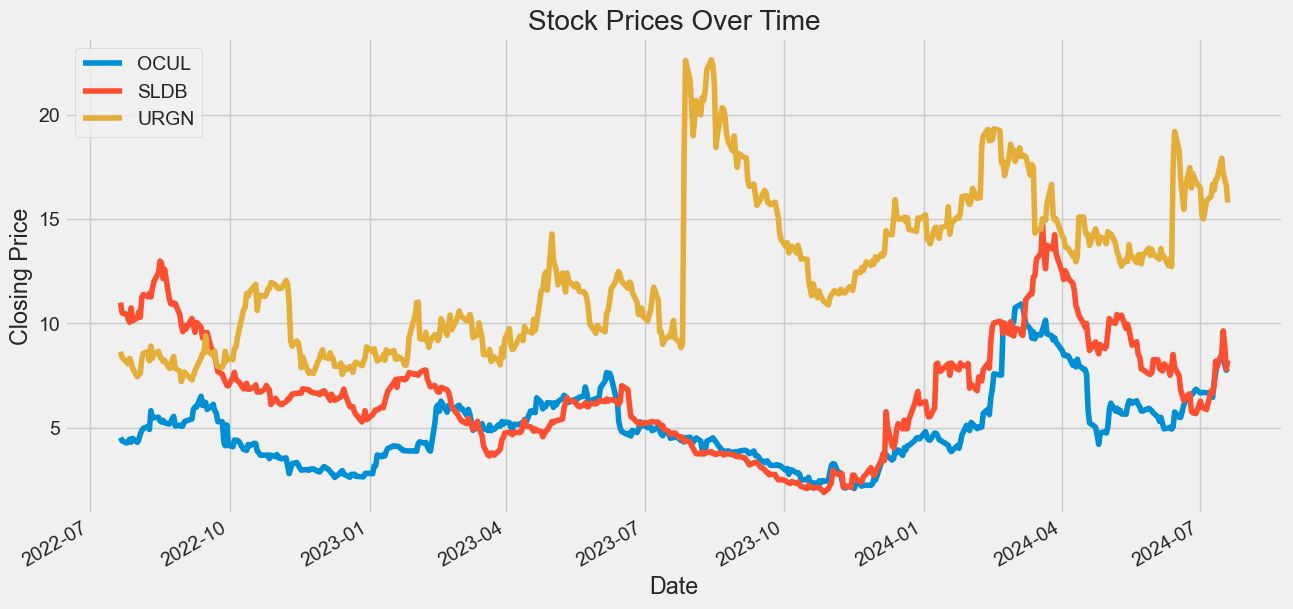

In [10]:
for stock in tech_list:
    df[df['ticker_symbol'] == stock]['Close'].plot(label=stock, figsize=(14, 7))
plt.legend()
plt.title('Stock Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

### Stock Price Moving Averages visualization:

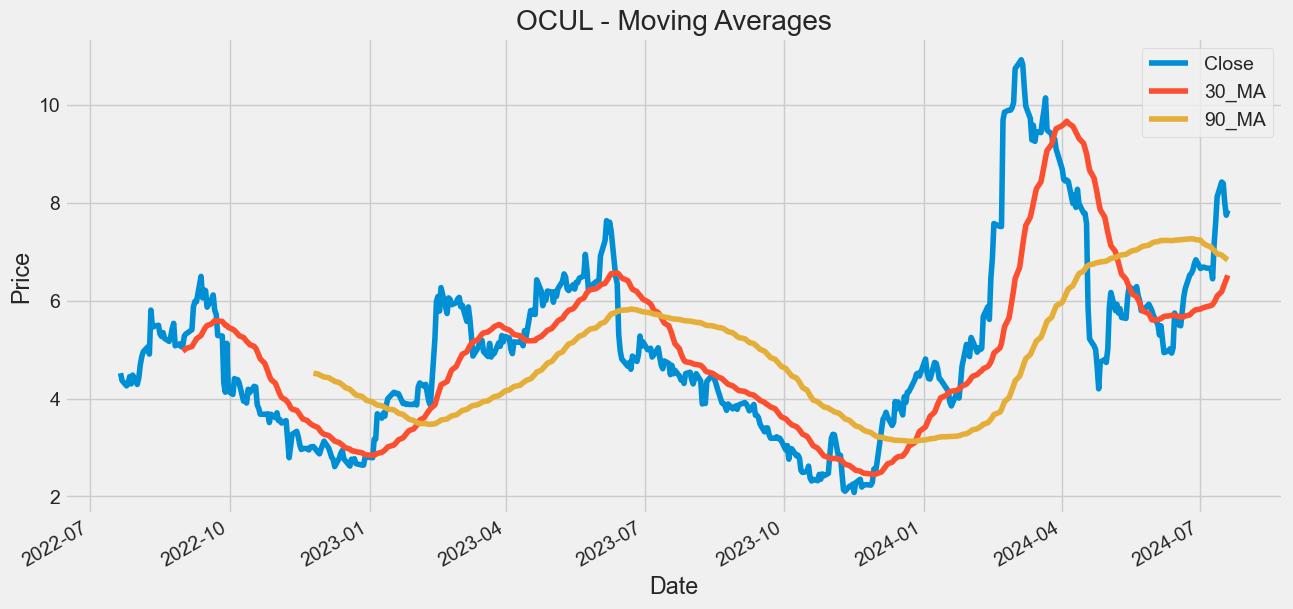

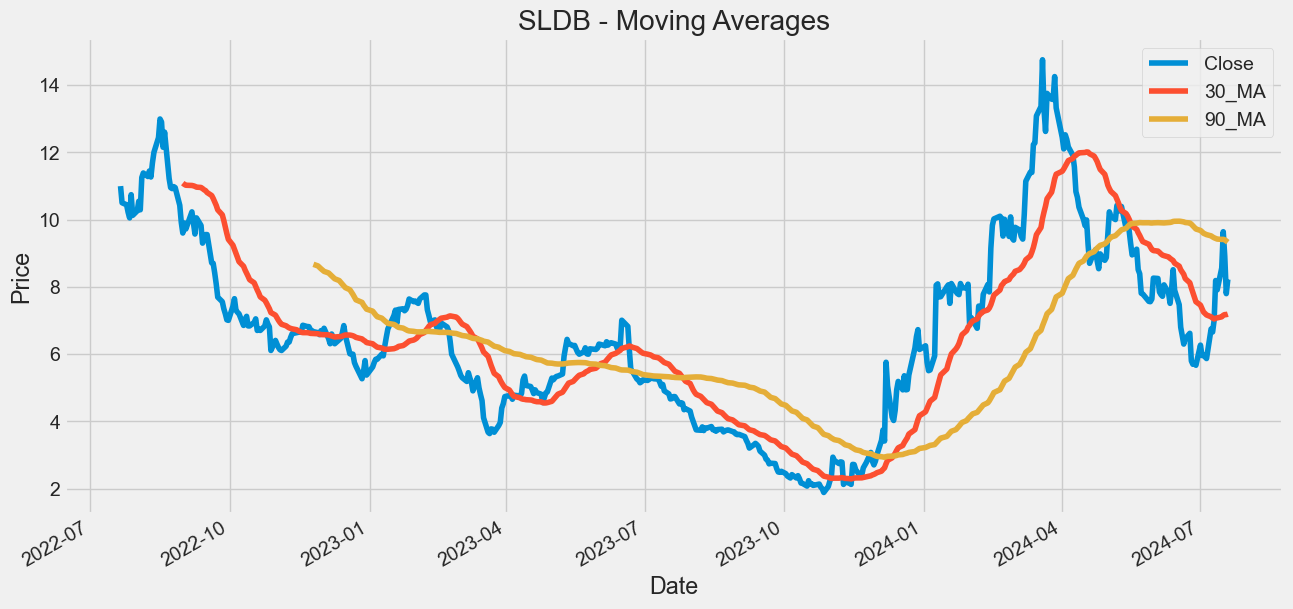

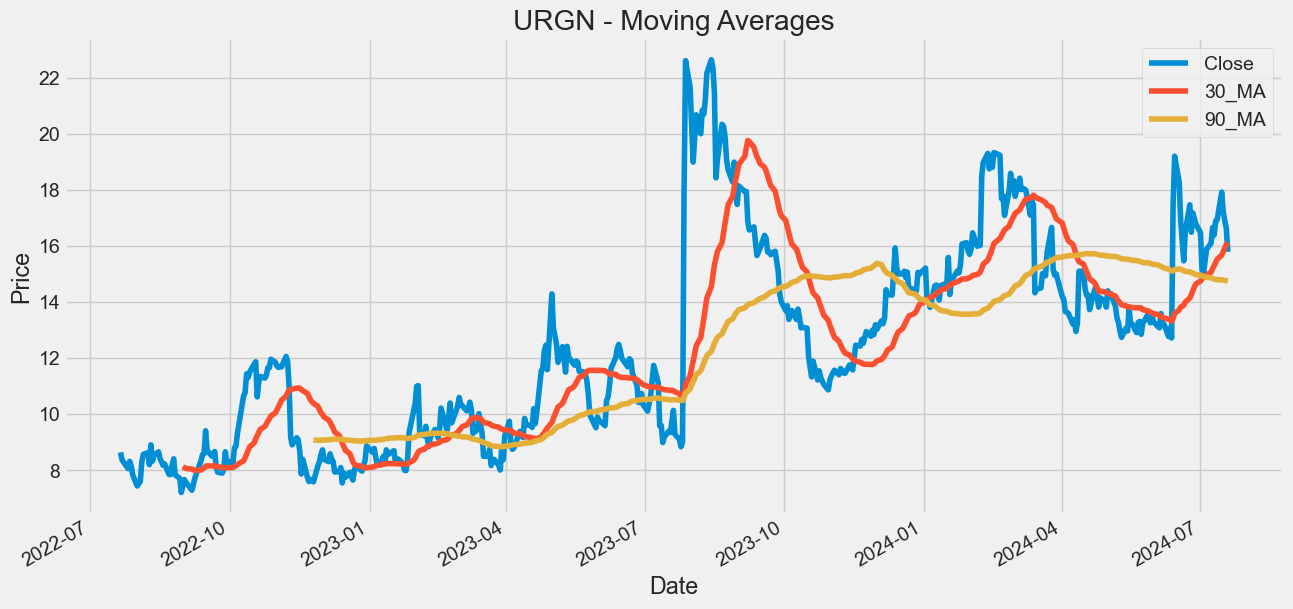

In [12]:
for stock in tech_list:
    df_stock = df[df['ticker_symbol'] == stock]
    df_stock['30_MA'] = df_stock['Close'].rolling(window=30).mean()
    df_stock['90_MA'] = df_stock['Close'].rolling(window=90).mean()
    df_stock[['Close', '30_MA', '90_MA']].plot(label=stock, figsize=(14, 7))
    plt.title(f'{stock} - Moving Averages')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()

### Visualization trade volume 

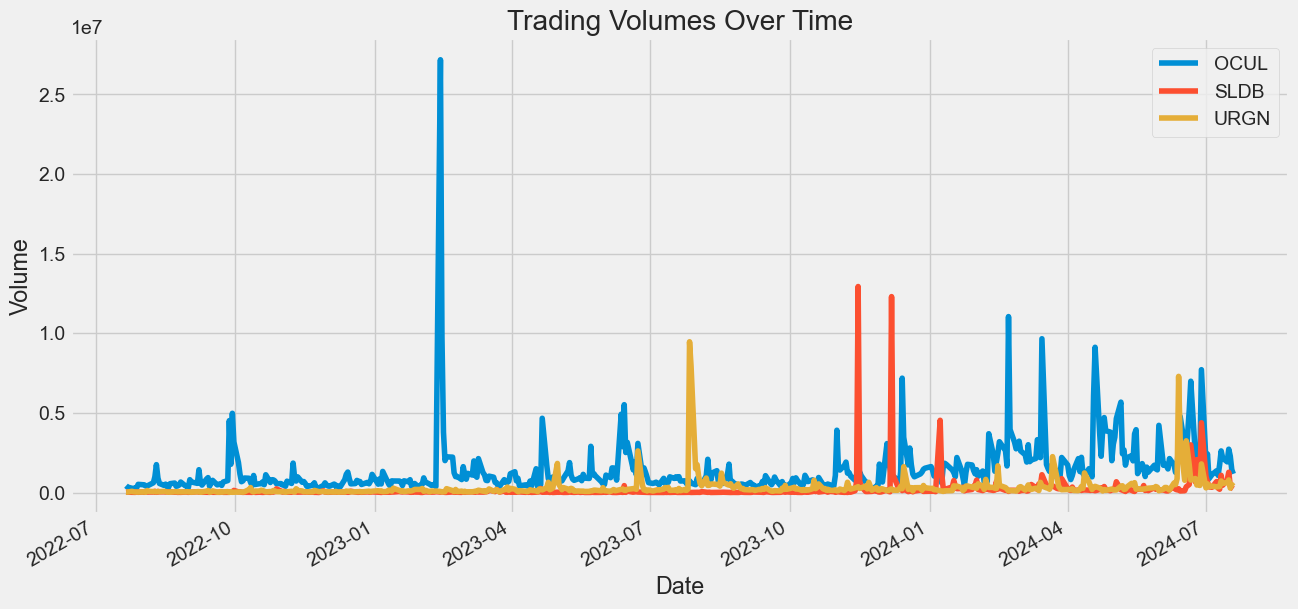

In [13]:
for stock in tech_list:
    df[df['ticker_symbol'] == stock]['Volume'].plot(label=stock, figsize=(14, 7))
plt.legend()
plt.title('Trading Volumes Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()

### Correlation Analysis

In [14]:
closing_prices = df.pivot_table(values='Close', index=df.index, columns='ticker_symbol')
corr_matrix = closing_prices.corr()
corr_matrix.reset_index()

ticker_symbol,ticker_symbol,OCUL,SLDB,URGN
0,OCUL,1.000000,0.642921,0.282954
1,SLDB,0.642921,1.000000,-0.073102
2,URGN,0.282954,-0.073102,1.000000


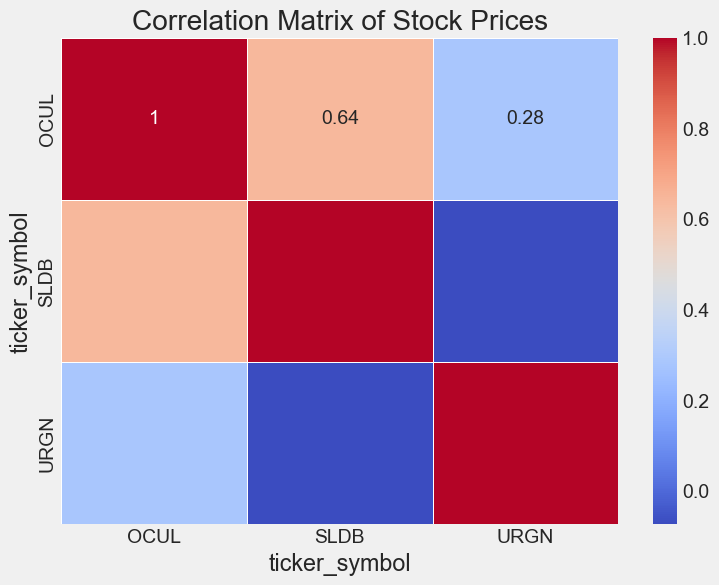

In [15]:
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Stock Prices')
plt.show()

### Visualization - Relative Strength Index

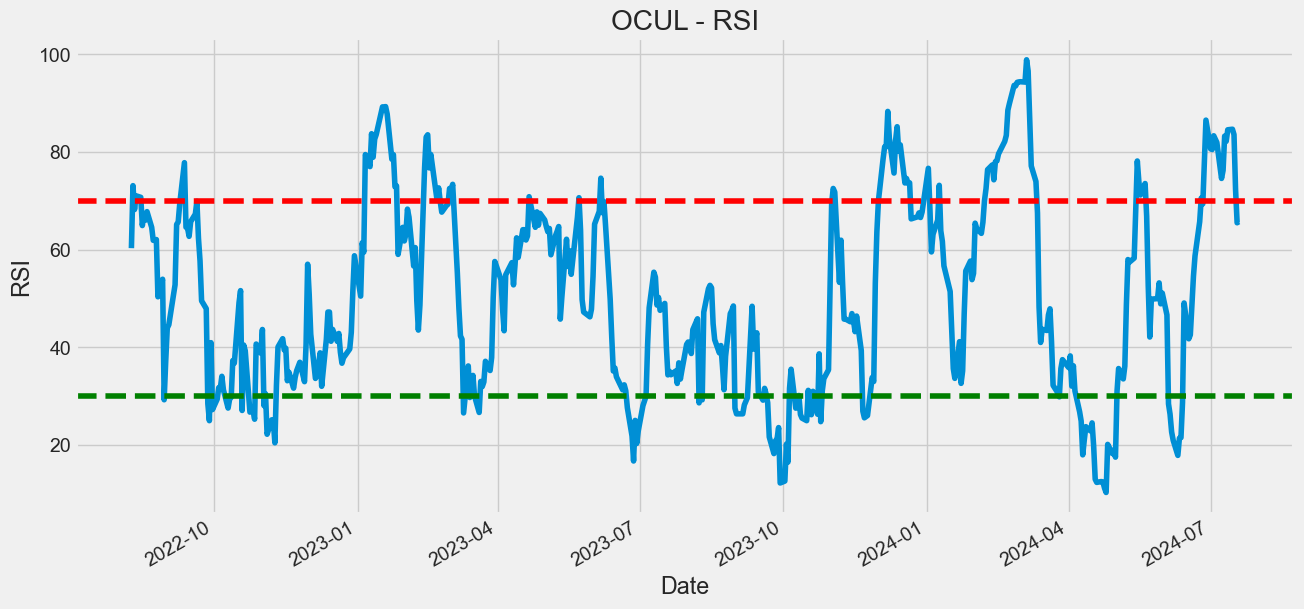

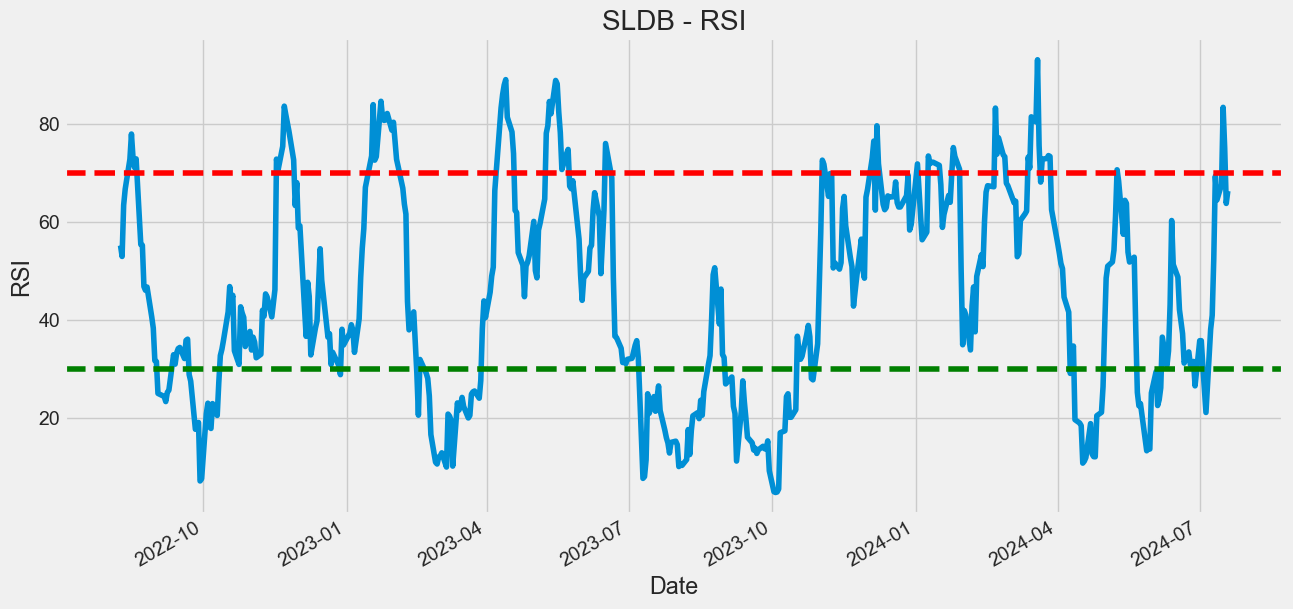

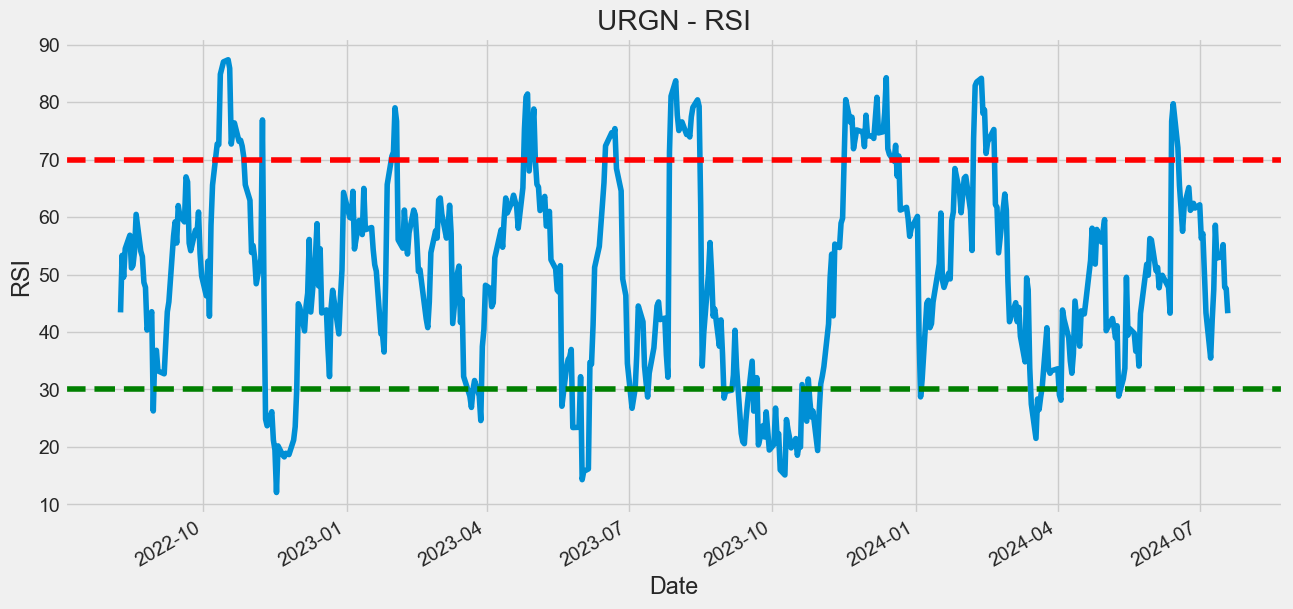

In [17]:
def compute_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

for stock in tech_list:
    df_stock = df[df['ticker_symbol'] == stock]
    df_stock['RSI'] = compute_rsi(df_stock)
    df_stock['RSI'].plot(label=stock, figsize=(14, 7))
    plt.axhline(70, color='r', linestyle='--')
    plt.axhline(30, color='g', linestyle='--')
    plt.title(f'{stock} - RSI')
    plt.xlabel('Date')
    plt.ylabel('RSI')
    plt.show()

### Visualizatrion - Moving Average Convergence Divergence (MACD):

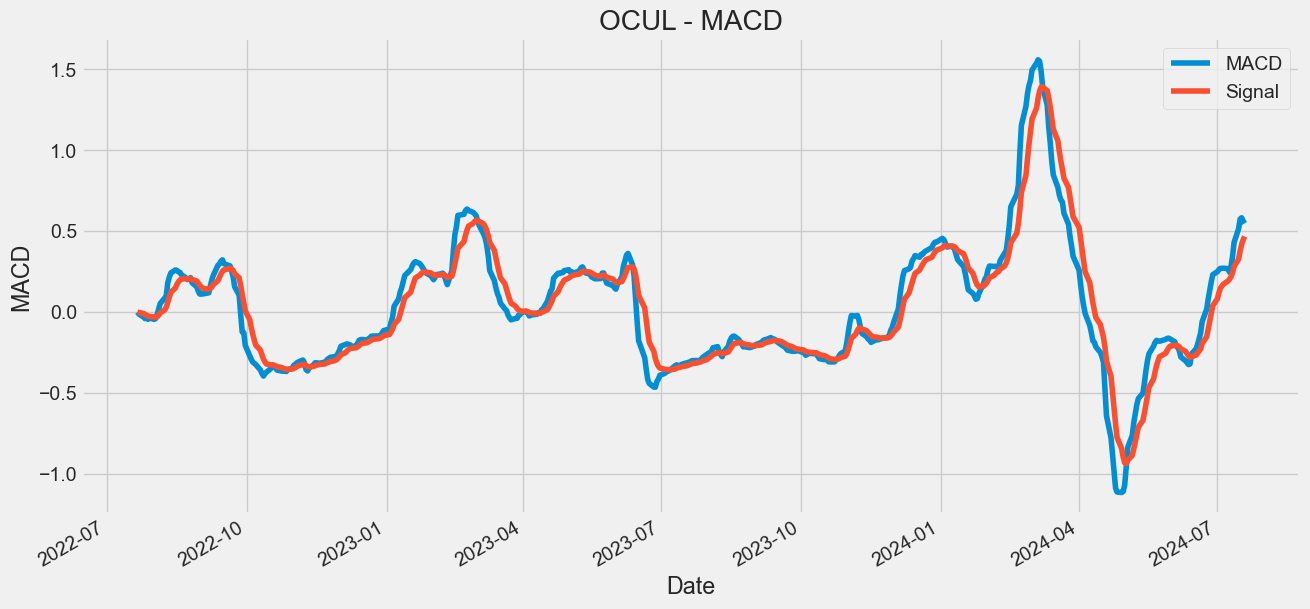

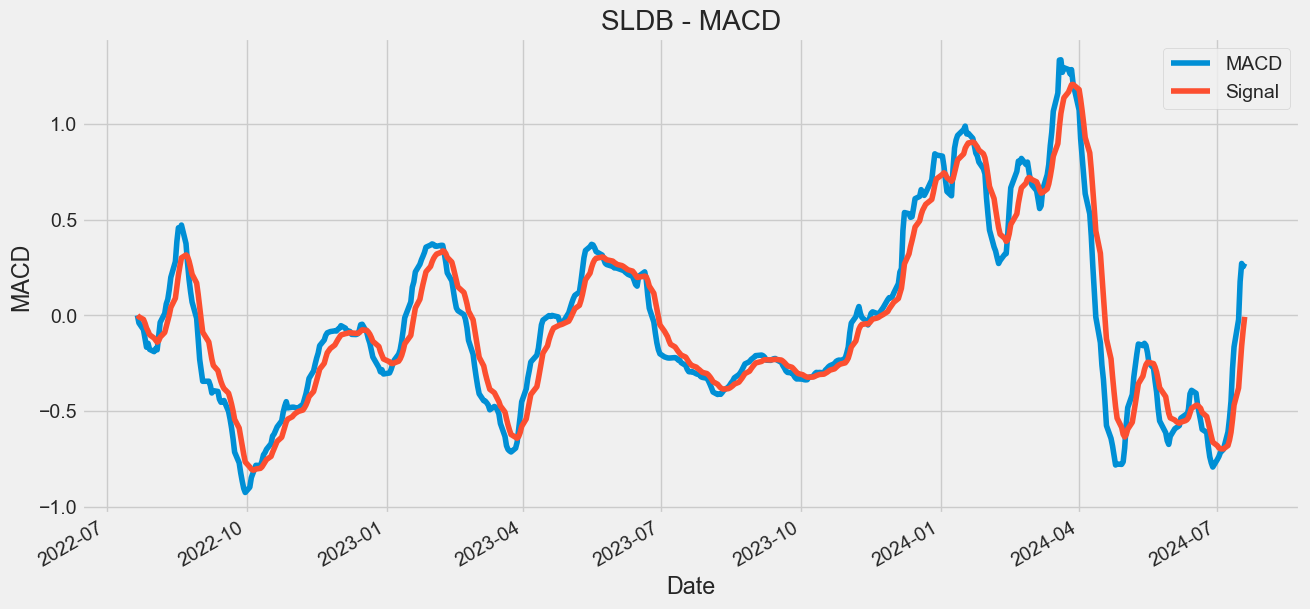

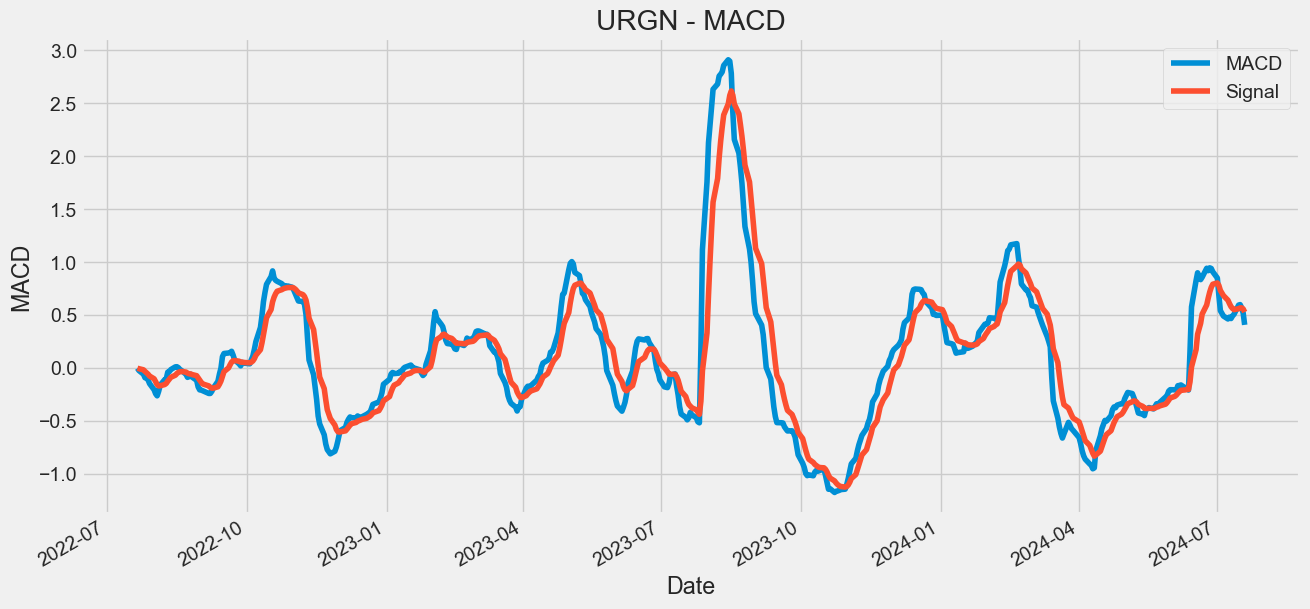

In [18]:
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = data['Close'].ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal

for stock in tech_list:
    df_stock = df[df['ticker_symbol'] == stock]
    df_stock['MACD'], df_stock['Signal'] = compute_macd(df_stock)
    df_stock[['MACD', 'Signal']].plot(label=stock, figsize=(14, 7))
    plt.title(f'{stock} - MACD')
    plt.xlabel('Date')
    plt.ylabel('MACD')
    plt.show()

### Visualization - Daily Percentage Change:

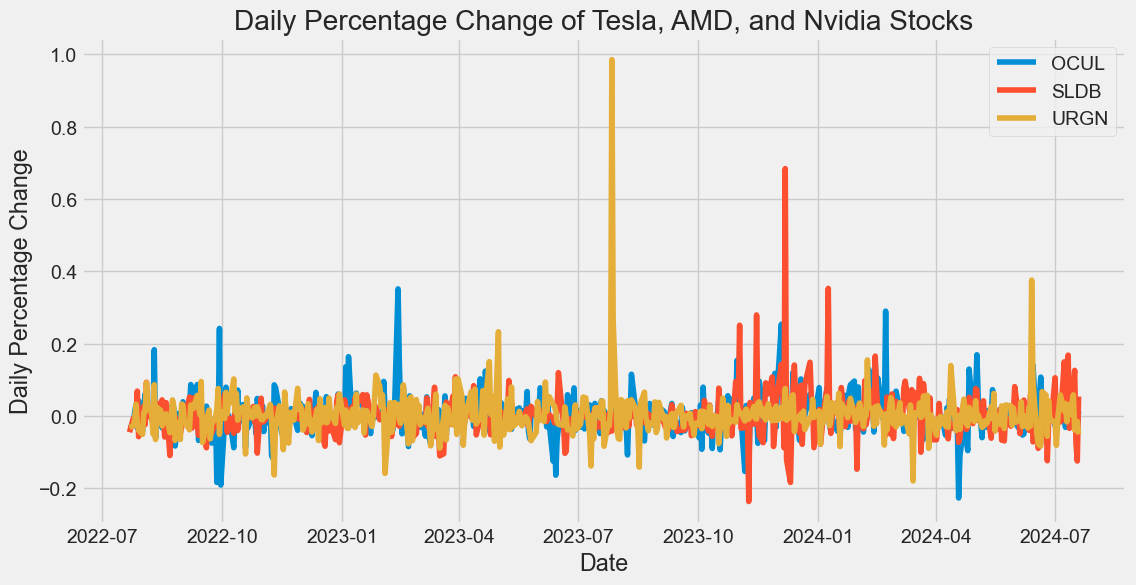

In [19]:
# Calculate daily percentage change
df['Daily_Return'] = df.groupby('ticker_symbol')['Close'].pct_change()

# Plotting
plt.figure(figsize=(12, 6))
for stock in tech_list:
    plt.plot(df[df['ticker_symbol'] == stock].index, 
             df[df['ticker_symbol'] == stock]['Daily_Return'], 
             label=stock)

plt.title('Daily Percentage Change of Tesla, AMD, and Nvidia Stocks')
plt.xlabel('Date')
plt.ylabel('Daily Percentage Change')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Add moving averages, RSI, and MACD variables to the main DataFrame
for stock in tech_list:
    mask = df['ticker_symbol'] == stock
    df.loc[mask, '30_MA'] = df.loc[mask, 'Close'].rolling(window=30).mean()
    df.loc[mask, '90_MA'] = df.loc[mask, 'Close'].rolling(window=90).mean()
    df.loc[mask, 'RSI'] = compute_rsi(df[mask])
    macd, signal = compute_macd(df[mask])
    df.loc[mask, 'MACD'] = macd
    #df.loc[mask, 'Signal'] = signal
df.tail(10)

,ticker_symbol,company_name,Open,High,Low,Close,Adj Close,Volume,Daily_Return,30_MA,90_MA,RSI,MACD
Date,,,,,,,,,,,,,
2024-07-08,URGN,URGN,15.980000,16.459999,15.900000,16.100000,16.100000,357500,0.013854,15.064000,14.860556,35.459660,0.464967
2024-07-09,URGN,URGN,16.059999,16.670000,15.952000,16.660000,16.660000,366100,0.034783,15.191000,14.843778,42.135918,0.482489
2024-07-10,URGN,URGN,16.680000,16.760000,16.280001,16.389999,16.389999,373700,-0.016207,15.296000,14.822222,47.379905,0.469180
2024-07-11,URGN,URGN,16.540001,17.299999,16.450001,16.889999,16.889999,726300,0.030506,15.405333,14.812444,58.595637,0.493292
2024-07-12,URGN,URGN,17.100000,17.379999,16.459999,16.930000,16.930000,568900,0.002368,15.527667,14.795889,52.892562,0.509752
2024-07-15,URGN,URGN,17.139999,18.070000,16.969999,17.920000,17.920000,625600,0.058476,15.673333,14.794889,53.086425,0.595814
2024-07-16,URGN,URGN,18.150000,18.150000,17.010000,17.219999,17.219999,788500,-0.039063,15.804000,14.785667,55.206843,0.600611
2024-07-17,URGN,URGN,17.219999,17.270000,16.549999,16.889999,16.889999,276900,-0.019164,15.929333,14.773000,47.819542,0.571200
2024-07-18,URGN,URGN,16.730000,16.840000,16.070000,16.639999,16.639999,500900,-0.014802,16.048000,14.758000,47.533633,0.521704
